# Clustering changes?

In [168]:
from ipynb.fs.full.koselleck import *

In [169]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None, combine_models=False):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    if combine_models:
        o=union_align_gensim(base_embed,other_embed)
    else:
        o=other_embed
    return o
    

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
    return (m1,m2)


def union_align_gensim(m1, m2, words=None, suffix1='_m1',suffix2='_m2'):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    new_arr_both=[]
    common_vocab_both=[w+suffix1 for w in common_vocab] + [w+suffix2 for w in common_vocab]
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = [old_arr[index] for index in indices]
        new_arr_both+=new_arr
    
#     odf=pd.DataFrame(new_arr_both,index=common_vocab_both)
#     return odf
    
    m.wv.vectors = np.array(new_arr_both)

    # Replace old vocab dictionary with new one (with common vocab)
    # and old index2word with new one
    new_key_to_index = {}
    new_index_to_key = []
    for new_index, key in enumerate(common_vocab_both):
        new_key_to_index[key] = new_index
        new_index_to_key.append(key)
    m.wv.key_to_index = new_key_to_index
    m.wv.index_to_key = new_index_to_key
    return m

In [170]:

def get_cdist_change_data(fn=FN_DATA_CDISTMATDF_CACHE,force=False):
    if not force and os.path.exists(fn): return read_df(fn)
    dfpaths=get_model_paths_sattelzeit().set_index('period')

    m1=load_model(dfpaths.loc['1700-1770'].sample(n=1).iloc[0].path)
    m2=load_model(dfpaths.loc['1830-1900'].sample(n=1).iloc[0].path)

    smart_procrustes_align_gensim(m1,m2,combine_models=False)
    
    vocab=m1.wv.index_to_key[:10000]
    wdistvecs1=[
        m1.wv.vectors[m1.wv.key_to_index[w]]
        for w in vocab
    ]
    wdistvecs2=[
        m2.wv.vectors[m2.wv.key_to_index[w]]
        for w in vocab
    ]
    wdistvecs_ch=[
        m2.wv.vectors[m2.wv.key_to_index[w]]-m1.wv.vectors[m1.wv.key_to_index[w]]
        for w in vocab
    ]
    wdistmat1=pd.DataFrame(wdistvecs1,index=vocab)
    wdistmat2=pd.DataFrame(wdistvecs2,index=vocab)
    wdistmat_ch=pd.DataFrame(wdistvecs_ch,index=vocab)
    
    print('Calculating word-change distances (m1)',timer=False)
    cdistmat1=fastdist.cosine_pairwise_distance(wdistmat1.values.astype(float),return_matrix=True)
    print('Calculating word-change distances (m2)')
    cdistmat2=fastdist.cosine_pairwise_distance(wdistmat2.values.astype(float),return_matrix=True)
    print('Calculating word-change distances (m2-m1)')
    cdistmat_ch=fastdist.cosine_pairwise_distance(wdistmat_ch.values.astype(float),return_matrix=True)
    
    print('Gathering in dataframe')
    cdistmatdf1=2-pd.DataFrame(cdistmat1,index=wdistmat1.index,columns=wdistmat1.index)
    cdistmatdf2=2-pd.DataFrame(cdistmat2,index=wdistmat2.index,columns=wdistmat2.index)
    cdistmatdf_ch=2-pd.DataFrame(cdistmat_ch,index=wdistmat_ch.index,columns=wdistmat_ch.index)
    cdistmatdf_ch
    
    cdistmatdfs_cache=[cdistmatdf1,cdistmatdf2,cdistmatdf_ch]
    with open(fn,'wb') as of: pickle.dump(cdistmatdfs_cache, of)
    return cdistmatdfs_cache

In [171]:
cdistmatdf1,cdistmatdf2,cdistmatdf_ch = get_cdist_change_data(force=False)

In [172]:
# cdistmatdf_ch.sort_values('growth').head(25)

In [6]:
# cdistmatdf1.sort_values('growth').head(25)

## combine into ranks

In [7]:
def do_get_cdist_change_ranks(obj):
    o=[]
    w,s1,s2,s_ch,k=obj
    s1=s1.sort_values()
    s2=s2.sort_values()
    s_ch=s_ch.sort_values()
    nbl1=list(s1.index)
    nbl1d={w:i for i,w in enumerate(nbl1)}
    
    nbl2=list(s2.index)
    nbl2d={w:i for i,w in enumerate(nbl2)}
    
    nbl_ch=list(s_ch.index)
    nbl_chd={w:i for i,w in enumerate(nbl_ch)}
    metanb=set(nbl1[:k])|set(nbl2[:k])|set(nbl_ch[:k])
    
    for w2 in metanb:
        odx={
            'word':w,
            'neighbor':w2,
            'rank1':nbl1d.get(w2,np.nan)+1,
            'rank2':nbl2d.get(w2,np.nan)+1,
            'rank_ch':nbl_chd.get(w2,np.nan)+1,
        }
        o+=[odx]
    return pd.DataFrame(o)
    
FN_DATA_CDISTMATDF_CACHE_RANKS=FN_DATA_CDISTMATDF_CACHE.replace('.pkl','.ranks.pkl')
DF_DATA_CDISTMATDF_CACHE_RANKS=None
def get_cdist_change_ranks(fn=FN_DATA_CDISTMATDF_CACHE_RANKS,k=100,num_proc=1,lim=None,force=False):
    global DF_DATA_CDISTMATDF_CACHE_RANKS
    if not force and DF_DATA_CDISTMATDF_CACHE_RANKS is not None: return DF_DATA_CDISTMATDF_CACHE_RANKS
    elif not force and os.path.exists(fn):
        odf=read_df(fn)
    else:
        cdistmatdf1,cdistmatdf2,cdistmatdf_ch=get_cdist_change_data()
        words=list(set(cdistmatdf1.index) & set(cdistmatdf2.index) & set(cdistmatdf_ch.index))
        objs=[
            (
                w,
                cdistmatdf1[w],
                cdistmatdf2[w],
                cdistmatdf_ch[w],
                k
            )
            for w in words[:lim]
        ]
        o=pmap(do_get_cdist_change_ranks,objs,num_proc=num_proc)
        odf=pd.concat(o) if len(o) else pd.DataFrame()
        odf.to_pickle(fn)
    odf=odf.set_index(['word','neighbor']).sort_values(['word','rank_ch'],ascending=[1,1])
    odf['rank_ch_diff']=odf[['rank1','rank2']].min(axis=1)-odf['rank_ch']
    DF_DATA_CDISTMATDF_CACHE_RANKS=odf
    return odf

In [8]:
odf=get_cdist_change_ranks(lim=None,num_proc=4)
odf

rank1  rank2  rank_ch  rank_ch_diff
word neighbor                                     
a'   a'            1      1        1             0
     o'           99      2        2             0
     wi'         106      3        3             0
     nae         499      5        4             1
     hae        1045     51        5            46
...              ...    ...      ...           ...
zs   gd            7    471     9907         -9900
     fid        1620     79     9914         -9835
     kv          980     52     9926         -9874
     uv         1061     40     9936         -9896
     wv           51    720     9972         -9921

[2372971 rows x 4 columns]

In [9]:
odf['rank_ch_diff']=odf[['rank1','rank2']].min(axis=1)-odf['rank_ch']
# odf.sort_values('rank_ch_diff')

In [10]:
# odf.loc['station'].sort_values('rank_ch_diff',ascending=False).head(25)

In [11]:
# odf.query('rank1>100 & rank2>100').loc['culture'].sort_values('rank_ch',ascending=True).head(25)

In [12]:
# odf.loc['growth','progress']

In [13]:
def get_word_simchange(w,min_normal_rank=100,sby='(III)',smin=.75):
    df=get_cdist_change_ranks()
    if w not in set(x for x,y in df.index): return pd.DataFrame()
    dfsimchanges=df.query(f'word=="{w}"').query(f'rank1>{min_normal_rank} & rank2>{min_normal_rank}').sort_values('rank_ch')
    try:
        tdf1=get_tilts_sattelzeit(w).loc[w]
    except KeyError:
        return pd.DataFrame()
    tdf1a,tdf1b=tdf1[tdf1[sby]>smin],tdf1[tdf1[sby]<-smin]
    simvecs=[]
    for w1,w2 in dfsimchanges.index:
        simvec=[]
        try:
            tdf2=get_tilts_sattelzeit(w2).loc[w2]
        except KeyError:
            simvecs+=['']
            continue
        tdf2a,tdf2b=tdf2[tdf2[sby]>smin],tdf2[tdf2[sby]<-smin]
        sharedposvecs={v.split('.')[0] for v in set(tdf1a.index)&set(tdf2a.index)}
        sharednegvecs={v.split('.')[0] for v in set(tdf1b.index)&set(tdf2b.index)}
        for v in sharedposvecs:
            va,vb=v.split('-') if v.count('-') else (v,v)
            simvec.append(f'+{va}')
        for v in sharednegvecs:
            va,vb=v.split('-') if v.count('-') else (v,v)
            vltr='-' if va==vb else '+'
            simvec.append(vltr+vb)
        simvecs.append(' '.join(simvec))
    dfsimchanges['sim_vecs']=simvecs
    return dfsimchanges

def info_word_simchange(w,k=25,**y):
    df=get_word_simchange(w,**y).loc[w]
    for x in df.columns:
        if x.startswith('rank'):
            df[x]=df[x].apply(lambda _: f'{_:,}') if not x.endswith('diff') else df[x].apply(lambda _: f'{_:+,}')
    df=df.iloc[:k]#.set_index('neighbor')
    df=df[['rank_ch','rank1','rank2','rank_ch_diff','sim_vecs']]
    df.columns=[
        'Rank for similarity in change vector',
        'Rank similarity in 1700-1770',
        'Rank similarity in 1830-1900',
        'Rank difference between change vector and actual ranks',
        'Similar vectors of change undergone by the neighbor'
    ]
    return df.rename_axis('Neighbor').to_markdown()


In [14]:
dfx=get_word_simchange('liberal')
dfx

rank1  rank2  rank_ch  rank_ch_diff  \
word    neighbor                                            
liberal peel           7915    194        8           186   
        cabinet        4613    236       11           225   
        leader         4478    170       18           152   
        abolition      4227    167       20           147   
        papal          4006    460       22           438   
...                     ...    ...      ...           ...   
        reformed       2120    132       96            36   
        romish         2561    293       97           196   
        unwilling      1102    805       98           707   
        entertaining    247    809       99           148   
        insurrection   9409   2012      100          1912   

                                               sim_vecs  
word    neighbor                                         
liberal peel          +Polit +Strong -Ambig +Man +Quant  
        cabinet                                  +Polit  
        leader                            +Strong +Freq  
        abolition                  +Active -Ambig +Pain  
        papal                                    +Polit  
...                                                 ...  
        reformed                          +Polit -Ambig  
        romish                                           
        unwilling                                        
        entertaining                             -Ambig  
        insurrection                                     

[62 rows x 5 columns]

In [15]:
# for w,wdf in dfx.groupby('word'): pass
# wdf.loc[w]

In [16]:
printm(info_word_simchange('liberal'))

| Neighbor    |   Rank for similarity in change vector | Rank similarity in 1700-1770   | Rank similarity in 1830-1900   | Rank difference between change vector and actual ranks   | Similar vectors of change undergone by the neighbor   |
|:------------|---------------------------------------:|:-------------------------------|:-------------------------------|:---------------------------------------------------------|:------------------------------------------------------|
| peel        |                                      8 | 7,915                          | 194                            | +186                                                     | +Polit +Strong -Ambig +Man +Quant                     |
| cabinet     |                                     11 | 4,613                          | 236                            | +225                                                     | +Polit                                                |
| leader      |                                     18 | 4,478                          | 170                            | +152                                                     | +Strong +Freq                                         |
| abolition   |                                     20 | 4,227                          | 167                            | +147                                                     | +Active -Ambig +Pain                                  |
| papal       |                                     22 | 4,006                          | 460                            | +438                                                     | +Polit                                                |
| deputation  |                                     23 | 5,783                          | 294                            | +271                                                     | +Pain +Neg                                            |
| dissolution |                                     24 | 7,519                          | 1,283                          | +1,259                                                   | +Polit -Ambig +Pain                                   |
| transaction |                                     25 | 6,564                          | 700                            | +675                                                     | +Polit +Active                                        |
| crisis      |                                     28 | 7,757                          | 1,224                          | +1,196                                                   | +Polit +Strong +Pain                                  |
| policies    |                                     33 | 1,614                          | 484                            | +451                                                     |                                                       |
| cheers      |                                     34 | 2,085                          | 453                            | +419                                                     |                                                       |
| largest     |                                     35 | 5,236                          | 698                            | +663                                                     | -Ambig                                                |
| estimates   |                                     36 | 7,718                          | 224                            | +188                                                     | +Active +Strong                                       |
| pledge      |                                     39 | 2,376                          | 1,190                          | +1,151                                                   | +Active -Ambig +Neg +Pain +Vice                       |
| currency    |                                     40 | 4,549                          | 322                            | +282                                                     |                                                       |
| monopoly    |                                     41 | 3,058                          | 187                            | +146                                                     | +Active +Strong                                       |
| existing    |                                     42 | 6,819                          | 492                            | +450                                                     | +Freq +Polit +Active +Strong +Pain +Quant             |
| proclaim    |                                     43 | 3,353                          | 4,123                          | +3,310                                                   | +Vice +Pain +Quant                                    |
| legislative |                                     45 | 3,884                          | 161                            | +116                                                     | +Pain                                                 |
| agriculture |                                     46 | 122                            | 231                            | +76                                                      | +Polit +Vice +Pain +Neg                               |
| precepts    |                                     47 | 301                            | 1,370                          | +254                                                     | +Pain                                                 |
| cuba        |                                     50 | 9,753                          | 1,003                          | +953                                                     |                                                       |
| resign      |                                     51 | 2,943                          | 1,379                          | +1,328                                                   | +Active -Ambig +Neg +Pain +Vice                       |
| statesmen   |                                     52 | 282                            | 139                            | +87                                                      | +Polit +Strong +Pain +Quant                           |
| landlord    |                                     53 | 3,298                          | 665                            | +612                                                     | +Polit +Strong +Man                                   |

In [17]:
# fdf=get_tilts_sattelzeit(w).loc[w]
# fdf=fdf[fdf['(III)']>1]

# fdf

In [18]:
# format_tilts_sattelzeit_html(w)

In [19]:
words=get_valid_words()[:10]
len(words)

10

In [20]:
FN_ALL_SIMCHANGES=os.path.join(PATH_DATA,'data.all_sim_changes.pkl')
DFALLSIMCHANGES=None

def get_all_simchanges(fn=FN_ALL_SIMCHANGES,words=None,force=False,lim=None,num_proc=1,lim_nbr=100):
    global DFALLSIMCHANGES
    if not force and DFALLSIMCHANGES is not None: return DFALLSIMCHANGES
    odf=pd.DataFrame()
    if not force:
        with get_veclib('simchange') as vl:
            odf=pd.concat(df.assign(word=w) for w,df in tqdm(vl.items())).reset_index().set_index(['word','neighbor'])
    else:
        with get_veclib('simchange') as vl:
            words_done=set(vl.keys())
            print(f'Already have data for {len(words_done)} words')
            words=get_valid_words() if not words else words
            words=[w for w in words if w not in words_done]
            for i,dfg in enumerate(pmap_iter(
                get_word_simchange,
                words[:lim],
                num_proc=num_proc
            )):
                if dfg is None or not len(dfg): continue
                dfg=dfg.query('rank1>100 & rank2>100').sort_values('rank_ch_diff').iloc[:lim_nbr]
                for w,wdf in dfg.groupby('word'): vl[w]=wdf.loc[w]
                if i and not i%25: vl.commit()
            vl.commit()
        odf=get_all_simchanges(force=False)
    DFALLSIMCHANGES=odf
    return odf

In [21]:
# !rm ../db/db.koselleck.simchange.sqlite

In [22]:
odf=get_all_simchanges(lim=None,num_proc=6,force=False)
odf

6851it [00:04, 1569.88it/s]


rank1  rank2  rank_ch  rank_ch_diff sim_vecs
word    neighbor                                                 
long    generation    2427    115       54            61   -Ambig
        along          746    110       13            97         
        straight      3499    153       42           111         
        twilight       741    204       83           121         
        some           274    144       16           128         
...                    ...    ...      ...           ...      ...
bladder christmas     9807   8310       56          8254         
        jubilee       9488   8587       92          8495         
        hospitality   9696   9040       94          8946         
        patriotic     9954   9992       91          9863   +Ambig
        scottish      9997   9982       93          9889         

[504915 rows x 5 columns]

## Change net?

In [23]:
# odf.groupby('word').head(3)

In [24]:
sing_nouns=get_valid_words({'nn1'})#[:200]
# len(sing_nouns)

In [25]:
# # okwords=set(sing_nouns) & set(odf.index.get_level_values('word'))
# okwords=set(get_valid_words()) & set(odf.index.get_level_values('word'))
# len(okwords)

In [26]:
# okodf=odf.loc[okwords]
# okodf

In [27]:
# odf[odf.sim_vecs.apply(lambda x: '+Abs' in x)]

In [28]:
# topdf=okodf.groupby('word').head(2)
# topdf

In [29]:
# okwords=set(sing_nouns) & set(odf.index.get_level_values('word'))
# # okwords=set(get_valid_words()) & set(odf.index.get_level_values('word'))
# len(okwords)

# okodf=odf.loc[okwords]
# okodf

# topdf=okodf.groupby('word').head(3)
# topdf

# G=nx.Graph()
# for (w1,w2),row in tqdm(topdf.iterrows(),total=len(topdf)):
#     G.add_edge(w1,w2)
#     for x in row.sim_vecs.split():
#         G.add_edge(w1,x)
# #         for w in [w1,w2]:
# #             G.add_edge(w,x)
# #     if G.order()>100: break
# print(G.order(),G.size())

# #pd.Series(dict(G.degree())).sort_values(ascending=False).head(25)

# deg1={w for w,c in G.degree() if c<2}
# G.remove_nodes_from(deg1)

# comp1=next(nx.connected_components(G))
# G.remove_nodes_from( set(G.nodes()) - set(comp1))
# print(G.order(),G.size())


In [30]:
# list(G.neighbors('+Ambig'))

In [31]:
# def draw_bokeh(G,
#     title='Networkx Graph', 
#     save_to=None,
#     color_by=None,
#     size_by=None,
#     default_color='skyblue',
#     default_size=15,
#     min_size=5,
#     max_size=30,
# ):
#     from bokeh.plotting import from_networkx
#     from bokeh.io import output_notebook, show, save
#     from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
#     from bokeh.plotting import figure
#     from bokeh.plotting import from_networkx
#     from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
#     from bokeh.transform import linear_cmap
#     from networkx.algorithms import community
#     from bokeh.io import output_notebook
#     output_notebook()

#     #Establish which categories will appear when hovering over each node
#     HOVER_TOOLTIPS = [("ID", "@index")]#, ("Relations")]

#     #Create a plot — set dimensions, toolbar, and title
#     # possible tools are pan, xpan, ypan, xwheel_pan, ywheel_pan, wheel_zoom, xwheel_zoom, ywheel_zoom, zoom_in, xzoom_in, yzoom_in, zoom_out, xzoom_out, yzoom_out, click, tap, crosshair, box_select, xbox_select, ybox_select, poly_select, lasso_select, box_zoom, xbox_zoom, ybox_zoom, save, undo, redo, reset, help, box_edit, line_edit, point_draw, poly_draw, poly_edit or hover
#     plot = figure(
#         tooltips = HOVER_TOOLTIPS,
#         tools="pan,wheel_zoom,save,reset,point_draw",
# #             active_scroll='wheel_zoom',
# #             tools="",
#         x_range=Range1d(-10.1, 10.1),
#         y_range=Range1d(-10.1, 10.1),
#         title=title
#     )

#     #Create a network graph object with spring layout
#     # https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html

#     #Set node size and color

#     # size?
#     size_opt = default_size
#     if size_by is not None:
#         size_opt = '_size'
#         data_l = X = np.array([d.get(size_by,0) for n,d in G.nodes(data=True)])
#         data_l_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#         data_scaled = [(min_size + (max_size * x)) for x in data_l_norm]
#         for x,n in zip(data_scaled, G.nodes()):
#             G.nodes[n]['_size']=x


#     # get network
#     network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))
    


#     # render nodes
#     network_graph.node_renderer.glyph = Circle(
#         size=size_opt, 
#         fill_color=color_by if color_by is not None else default_color
#     )

#     #Set edge opacity and width
#     network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#     #Add network graph to the plot
#     plot.renderers.append(network_graph)

#     #Add Labels
#     x, y = zip(*network_graph.layout_provider.graph_layout.values())
#     node_labels = list(G.nodes())
#     source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
#     labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
#     plot.renderers.append(labels)

#     show(plot)
#     if save_to: save(plot, filename=save_to)

In [32]:
# draw_bokeh(G)

## Cluster

In [33]:
# icols=list(set(sing_nouns[:1000]) & set(cdistmatdf_ch.index))
# ddf=cdistmatdf_ch.loc[icols][icols]
# ddf

In [34]:
# # !pip install umap hdbscan
# from sklearn.datasets import fetch_openml
# from sklearn.decomposition import PCA
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# # %matplotlib inline

# # Dimension reduction and clustering libraries
# import umap
# import hdbscan
# import sklearn.cluster as cluster
# from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [35]:
# sns.set(style='white', rc={'figure.figsize':(10,8)})

In [36]:
# mnist = fetch_openml('mnist_784', version=1)
# mnist.target = mnist.target.astype(int)

In [37]:
# standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
# standard_embedding

In [38]:
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

In [39]:
# lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
# hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

In [40]:
# clusterable_embedding = umap.UMAP(
#     n_neighbors=30,
#     min_dist=0.0,
#     n_components=2,
#     random_state=42,
# ).fit_transform(mnist.data)

In [41]:
# plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
#             c=mnist.target, s=0.1, cmap='Spectral');

In [42]:
okwords=set(get_signif_novelty_words()) & set(get_changeranks_sattelzeit().query('rank_word<5000').index)
len(okwords)

1429

In [43]:
cdistmatdf1,cdistmatdf2,cdistmatdf_ch = [
    cdf.loc[[w for w in cdf.index if w in okwords]][[w for w in cdf.columns if w in okwords]]
    for cdf in get_cdist_change_data(force=False)
]
cdistmatdf1.index=[w+'_I' for w in cdistmatdf1.index]
cdistmatdf2.index=[w+'_III' for w in cdistmatdf2.index]
cdistmatdf_ch.index=[w+'_I-III' for w in cdistmatdf_ch.index]

cdistmatdf = cdistmatdf1.append(cdistmatdf2).append(cdistmatdf_ch).dropna()
cdistmatdf

house          fame    author         large  \
house_I           -4.440892e-16  1.852740e+00  2.225588  1.935242e+00   
fame_I             1.852740e+00  2.220446e-16  1.930470  1.879969e+00   
author_I           2.225588e+00  1.930470e+00  0.000000  1.982432e+00   
large_I            1.935242e+00  1.879969e+00  1.982432  8.881784e-16   
french_I           2.076857e+00  1.938731e+00  2.080794  1.803118e+00   
...                         ...           ...       ...           ...   
destination_I-III  1.941908e+00  1.901700e+00  2.112245  2.077141e+00   
drunken_I-III      1.967574e+00  1.976407e+00  1.933167  2.053915e+00   
intrigue_I-III     1.870537e+00  1.721022e+00  1.747213  1.726752e+00   
nominal_I-III      2.004550e+00  2.109956e+00  1.838371  1.757469e+00   
decayed_I-III      2.055318e+00  2.052127e+00  2.062646  1.998450e+00   

                     french    street     price    public    number      high  \
house_I            2.076857  1.425008  2.049579  1.860457  1.880838  1.847379   
fame_I             1.938731  2.250896  2.140091  1.763021  1.939227  1.823788   
author_I           2.080794  2.131752  1.822609  1.706625  2.031453  2.193973   
large_I            1.803118  1.748609  1.723871  2.072328  1.689621  1.792610   
french_I           0.000000  2.079093  1.894807  2.107345  1.752852  2.069693   
...                     ...       ...       ...       ...       ...       ...   
destination_I-III  2.399284  2.028545  1.794813  2.078707  2.065539  2.215392   
drunken_I-III      2.109906  2.167076  2.003576  1.843554  2.132001  2.140063   
intrigue_I-III     1.816043  1.957658  2.027721  1.920215  2.286398  2.015393   
nominal_I-III      2.077455  1.928769  1.910614  1.709767  2.188794  1.973656   
decayed_I-III      1.885731  1.923745  1.792875  1.971769  2.173212  1.994490   

                   ...   strokes   arduous    triple  conversations     brink  \
house_I            ...  2.457061  2.275781  2.030042       2.178021  1.910441   
fame_I             ...  1.811923  2.124916  1.883924       2.139231  2.036843   
author_I           ...  1.536498  1.734883  2.281359       1.507333  2.269068   
large_I            ...  1.813390  1.977504  1.597548       1.946384  1.844692   
french_I           ...  2.084350  2.179980  1.622884       1.984796  1.787490   
...                ...       ...       ...       ...            ...       ...   
destination_I-III  ...  1.848496  1.840076  2.463737       2.126799  1.592444   
drunken_I-III      ...  1.732981  1.908197  2.140084       2.156093  2.101382   
intrigue_I-III     ...  1.988530  1.914338  2.055956       2.010107  2.152258   
nominal_I-III      ...  1.859265  1.578289  1.841542       2.139846  2.239823   
decayed_I-III      ...  1.908808  1.941451  1.832158       2.259736  1.870512   

                    destination   drunken  intrigue   nominal   decayed  
house_I            2.081691e+00  1.971637  1.912671  1.900645  1.965794  
fame_I             2.187260e+00  1.984029  2.140011  1.788351  2.005821  
author_I           1.850216e+00  2.231044  1.710815  2.002455  2.110039  
large_I            1.977792e+00  2.217194  2.116326  2.246521  1.465904  
french_I           1.550216e+00  2.269021  1.894139  2.080587  2.172310  
...                         ...       ...       ...       ...       ...  
destination_I-III -8.881784e-16  2.144152  2.123184  2.059754  2.158171  
drunken_I-III      2.144152e+00  0.000000  1.694602  1.696927  1.716367  
intrigue_I-III     2.123184e+00  1.694602  0.000000  1.721502  1.965629  
nominal_I-III      2.059754e+00  1.696927  1.721502  0.000000  1.922567  
decayed_I-III      2.158171e+00  1.716367  1.965629  1.922567  0.000000  

[4026 rows x 1342 columns]

In [44]:
ddf=cdistmatdf_ch
# icols=list(okwords & set(idf.index))
# ddf=idf.loc[icols][icols]
#ddf


In [45]:
def umap_for_plotting(ddf,suffix=''):
#     print('UMAP for plotting...')
    fit = umap.UMAP().fit_transform(ddf.select_dtypes('number').values)
    dffit=pd.DataFrame(fit,index=ddf.index, columns=['X1'+suffix,'X2'+suffix])#.rename_axis('word_prd')
    #dffit['word']=[x.split('_')[0] for x in dffit.index]
    #dffit['prd']=[x.split('_')[-1] for x in dffit.index]
    return dffit

In [46]:
# umap_for_plotting(cdistmatdf)

In [47]:
# fit_cdistmat(cdistmat)

In [181]:
def get_topmost_change(sby='(III)',cutoff=.5):
    sdf=get_tilts_sattelzeit().sort_values(['word','abs(III)'],ascending=[1,0])
    sdf1=sdf.groupby('word').head(1).reset_index()
    def class_change(row):
        vec=row.vector.split('.')[0]
        va,vb=vec.split('-') if '-' in vec else (vec,vec)
#         print(vec,va,vb)
        if row[sby]>cutoff:
            return '+'+va
        elif row[sby]<-cutoff:
            return '+'+vb if va!=vb else '-'+va
        else:
            return ''
        
    sdf1['change']=sdf1.apply(class_change,axis=1)
    sdf1=sdf1.set_index('word')
    return sdf1

In [180]:
sdf1=get_topmost_change()
sdf1

vector  1700-1770       (I)  1770-1830      (II)  \
word                                                                     
abandon  Collective-Indiv.RH  -1.031228  0.488935  -0.542294  0.802849   
abandon       Polit-Acad.HGI   2.198096 -0.765139   1.432956 -0.179365   
abandon         Woman-Man.VG  -0.592166  0.730302   0.138136  0.085611   
abandon          Pos-Neg.HGI  -0.297123  0.071572  -0.225551  0.525754   
abandon      Abs-Conc.Median   1.428809 -0.099356   1.329453  0.667309   
...                      ...        ...       ...        ...       ...   
zoo          Interp-Desc.HGI  -0.925453 -0.458869  -1.384321  0.817159   
zoo             Woman-Man.VG  -0.147298 -0.470728  -0.618026  0.707859   
zoo            Judg-Perc.HGI   0.605740 -0.065831   0.539909 -0.169218   
zoo          Abs-Conc.Median  -1.003702 -0.504730  -1.508432  0.669820   
zoo           Time-Space.HGI   0.197451 -0.086012   0.111439  0.089134   

         1830-1900     (III)  abs(III)       change  
word                                                 
abandon   0.260555  1.291783  1.291783  +Collective  
abandon   1.253592 -0.944504  0.944504        +Acad  
abandon   0.223746  0.815913  0.815913       +Woman  
abandon   0.300204  0.597327  0.597327         +Pos  
abandon   1.996762  0.567953  0.567953         +Abs  
...            ...       ...       ...          ...  
zoo      -0.567163  0.358290  0.358290               
zoo       0.089833  0.237132  0.237132               
zoo       0.370691 -0.235048  0.235048               
zoo      -0.838612  0.165090  0.165090               
zoo       0.200573  0.003122  0.003122               

[161576 rows x 9 columns]

In [122]:
sdf1.query('change=="+Abs"')

vector  1700-1770       (I)  1770-1830      (II)  \
word                                                                     
alien        Abs-Conc.Median   0.003080 -0.391598  -0.388518  2.195629   
callous      Abs-Conc.Median   0.083310  0.799310   0.882619  0.695366   
contagious   Abs-Conc.Median   0.514492 -0.256898   0.257594  1.105206   
convicted    Abs-Conc.Median  -0.019664 -0.064608  -0.084273  0.982219   
cordial      Abs-Conc.Median   0.009045  0.721863   0.730909  0.686193   
denounced    Abs-Conc.Median   1.099914 -0.428286   0.671628  1.376563   
dormant      Abs-Conc.Median   0.143241 -0.221565  -0.078324  1.253202   
erred        Abs-Conc.Median   0.603616  0.219253   0.822869  0.747432   
fails        Abs-Conc.Median  -0.077037 -0.402961  -0.479998  1.776031   
fathom       Abs-Conc.Median  -1.164242 -0.360027  -1.524269  1.924013   
fervent      Abs-Conc.Median   1.082943 -0.080424   1.002519  0.755619   
fits         Abs-Conc.Median  -0.653563 -0.334671  -0.988233  1.146510   
frenchmen    Abs-Conc.Median  -0.655520  0.012157  -0.643363  1.660399   
goo          Abs-Conc.Median  -1.076746 -0.078816  -1.155563  1.169522   
launched     Abs-Conc.Median  -1.211169 -0.122708  -1.333877  1.065003   
lax          Abs-Conc.Median  -0.621672  0.091293  -0.530379  2.114204   
lighten      Abs-Conc.Median  -0.246894  0.175256  -0.071638  0.719858   
pervades     Abs-Conc.Median   0.293317  0.352623   0.645940  1.008743   
revolted     Abs-Conc.Median   0.584159  0.456452   1.040611  0.490906   
spontaneous  Abs-Conc.Median   0.140967  0.026768   0.167735  1.884266   
viewing      Abs-Conc.Median  -0.435478 -0.181115  -0.616593  1.666689   

             1830-1900     (III)  abs(III) change  
word                                               
alien         1.807111  1.804031  1.804031   +Abs  
callous       1.577985  1.494676  1.494676   +Abs  
contagious    1.362800  0.848308  0.848308   +Abs  
convicted     0.897947  0.917611  0.917611   +Abs  
cordial       1.417102  1.408056  1.408056   +Abs  
denounced     2.048191  0.948277  0.948277   +Abs  
dormant       1.174878  1.031637  1.031637   +Abs  
erred         1.570300  0.966685  0.966685   +Abs  
fails         1.296032  1.373070  1.373070   +Abs  
fathom        0.399743  1.563985  1.563985   +Abs  
fervent       1.758137  0.675194  0.675194   +Abs  
fits          0.158276  0.811839  0.811839   +Abs  
frenchmen     1.017036  1.672555  1.672555   +Abs  
goo           0.013960  1.090706  1.090706   +Abs  
launched     -0.268874  0.942295  0.942295   +Abs  
lax           1.583825  2.205497  2.205497   +Abs  
lighten       0.648219  0.895113  0.895113   +Abs  
pervades      1.654682  1.361365  1.361365   +Abs  
revolted      1.531517  0.947358  0.947358   +Abs  
spontaneous   2.052000  1.911033  1.911033   +Abs  
viewing       1.050096  1.485574  1.485574   +Abs

In [123]:
# figdf=dffit.merge(sdf1,on='word').dropna().reset_index()
# figdf

In [124]:
# start_fig(figdf,x='X1',y='X2',label='word',color='prd') + p9.geom_text(size=5)

In [125]:
# hdbscan.HDBSCAN??

In [126]:
def umap_for_clustering(ddf,ndim=100,n_neighbors=30,min_dist=0.0,random_state=42,min_samples=None,min_cluster_size=5):
#     print('UMAP for clustering...')
    clusterable_embedding = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state,
        n_components=ndim,
    ).fit_transform(ddf.select_dtypes('number').values)    
    labels = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
    ).fit_predict(clusterable_embedding)
    return pd.DataFrame(index=ddf.index).assign(cluster=[f'C{x:02}' for x in labels])


In [127]:
# clustdf=umap_for_clustering(cdistmatdf2)
# clustdf.cluster.value_counts()

In [128]:
# def umap_ddf(ddf):
#     odf=umap_for_plotting(ddf).join(umap_for_clustering(ddf))
#     odf['word']=[x.split('_')[0] for x in odf.index]
#     odf['prd']=[x.split('_')[-1] for x in odf.index]
#     odf=odf.merge(get_topmost_change(),on='word')
#     odf=odf.set_index(['cluster','word','prd']).sort_index()
#     return odf

In [129]:
# figdf['cluster_I-III'].value_counts()
dfanno=read_sheet()
invalid_words=set(dfanno[dfanno.is_valid.str.startswith('n')].index)
len(invalid_words)

117

In [130]:
# get_valid_words??#

In [159]:
def umap_simchanges(topn=2000,words=None,pos={'n*','j*','v*'},add_words=set(),**kwargs):
    print('Getting words',timer=False)
    if not words:
        chwords=get_changeranks_sattelzeit().index
        novwords=set(get_signif_novelty_words())
        valwords=set(get_valid_words(only_pos=pos)) - invalid_words
        okwords=set([w for w in chwords if w in novwords and w in valwords][:topn])
    else:
        okwords=set(words)
    okwords|=add_words
    
    print('Loading data')
    cdfl = cdistmatdf1,cdistmatdf2,cdistmatdf_ch = [
        cdf.loc[[w for w in cdf.index if w in okwords]][[w for w in cdf.columns if w in okwords]]
        for cdf in get_cdist_change_data(force=False)
    ]
    suffices=['I','II','I-III']
    o=[]
    for suf,cdf in tqdm(list(zip(suffices,cdfl)),desc='[Koselleck] Loading data'):
        odf=umap_for_plotting(cdf).join(umap_for_clustering(cdf,**kwargs)).rename_axis('word')
        odf.columns=[c+'_'+suf for c in odf.columns]
        o.append(odf)
    odf=pd.concat(o,axis=1).join(get_topmost_change(),how='left')
    return odf

In [133]:
# figdf=udf.reset_index()
# figdf

In [134]:
# udf['cluster_I-III'].value_counts()

In [135]:
# start_fig(
#     figdf[figdf['cluster_II']!='C-1'],
#     x='X1_I-III',
#     y='X2_I-III',
#     label='word',
#     color='cluster_II'
# ) + p9.geom_text(size=5)

In [136]:
# start_fig(
#     figdf[figdf['cluster_I-II']!='C-1'],
#     x='X1_II',
#     y='X2_II',
#     label='word',
#     color='cluster_II'
# ) + p9.geom_text(size=5) + p9.facet_wrap('cluster_I-III')

In [137]:
# fig=p9.ggplot(
#     figdf[figdf['cluster_I-III']!='C-1'].sample(n=500),
#     p9.aes(
#         x='X1_I-III',
#         y='X2_I-III',
#         label='word',
#         shape='cluster_II',
# #         color='cluster_I-III',
# #         fill='cluster_I-III'
#     )
# ) + p9.geom_point(p9.aes(color='cluster_I-III',shape='cluster_II',opacity=.25),size=2) + p9.geom_text(
#     size=5#,label_size=0
# ) + p9.theme_classic() + p9.scale_color_discrete()
# fig

In [138]:
# fig=p9.ggplot(
#     figdf[figdf['cluster_I-III']!='C-1'].sample(n=500),
#     p9.aes(
#         x='X1_I-III',
#         y='X2_I-III',
#         label='word',
#         shape='cluster_II',
# #         color='cluster_I-III',
# #         fill='cluster_I-III'
#     )
# ) + p9.geom_point(p9.aes(color='cluster_I-III',shape='cluster_II',opacity=.25),size=2) + p9.geom_text(
#     size=5#,label_size=0
# ) + p9.theme_classic() + p9.scale_color_discrete()
# fig

In [139]:
# figdf=udf.reset_index()
# vdf=figdf.groupby('change').mean().reset_index()
# vdf=vdf.assign(word=vdf.change)
# figdf

In [140]:
# figdf[figdf['cluster_I-III']!='C-1']

In [141]:
# figdf['cluster_I'].value_counts()

In [182]:
# p9.options.figure_size=11,8
# start_fig(
#     figdf[(figdf['cluster_II']!='C-1') & (figdf['cluster_I-III']!='C-1')],
#     x='X1_I-III',
#     y='X2_I-III',
#     label='word',
# ) + p9.geom_point(p9.aes(color='cluster_II',opacity=.25),size=1,show_legend=False
# ) + p9.geom_text(size=5
# ) + p9.geom_text(size=8,data=vdf#,label_size=0
# ) + p9.theme_classic(
# ) + p9.scale_color_discrete(
# # ) + p9.facet_wrap('cluster_I-III'
# )

In [187]:
def get_all_signif_tilts(cutoff=.5,sby='(III)'):
    sdf=get_tilts_sattelzeit().sort_values(['word','abs(III)'],ascending=[1,0])
    
    def class_change(row):
        vec=row.vector.split('.')[0]
        va,vb=vec.split('-') if '-' in vec else (vec,vec)
#         print(vec,va,vb)
        if row[sby]>cutoff:
            return '+'+va
        elif row[sby]<-cutoff:
            return '+'+vb if va!=vb else '-'+va
        else:
            return ''
    sdf1=sdf.reset_index()
    sdf1['change']=sdf1.apply(class_change,axis=1)
    sdf1=sdf1.set_index('word')
    return sdf1[sdf1.change!='']
    

In [191]:


udf=umap_simchanges(words=get_keywords())

[Koselleck] (23:35:08) Getting words 
[Koselleck] (23:35:08) Loading data (+0.0s)
[Koselleck] Loading data:   0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'umap' is not defined

In [186]:
get_all_signif_tilts()

vector  1700-1770       (I)  1770-1830      (II)  \
word                                                                     
abandon  Collective-Indiv.RH  -1.031228  0.488935  -0.542294  0.802849   
abandon       Polit-Acad.HGI   2.198096 -0.765139   1.432956 -0.179365   
abandon         Woman-Man.VG  -0.592166  0.730302   0.138136  0.085611   
abandon          Pos-Neg.HGI  -0.297123  0.071572  -0.225551  0.525754   
abandon      Abs-Conc.Median   1.428809 -0.099356   1.329453  0.667309   
...                      ...        ...       ...        ...       ...   
zoo        Pleasure-Pain.HGI  -0.792002 -0.379044  -1.171046  1.386662   
zoo              Pos-Neg.HGI  -0.773752 -0.416227  -1.189979  1.233237   
zoo          Virtue-Vice.HGI  -0.513165 -0.547034  -1.060199  1.101552   
zoo                   Freq.M   0.113982 -0.333238  -0.219256 -0.202116   
zoo          Strong-Weak.HGI   0.494177  0.228617   0.722794 -0.731968   

         1830-1900     (III)  abs(III)       change  
word                                                 
abandon   0.260555  1.291783  1.291783  +Collective  
abandon   1.253592 -0.944504  0.944504        +Acad  
abandon   0.223746  0.815913  0.815913       +Woman  
abandon   0.300204  0.597327  0.597327         +Pos  
abandon   1.996762  0.567953  0.567953         +Abs  
...            ...       ...       ...          ...  
zoo       0.215616  1.007618  1.007618    +Pleasure  
zoo       0.043258  0.817010  0.817010         +Pos  
zoo       0.041353  0.554518  0.554518      +Virtue  
zoo      -0.421372 -0.535354  0.535354        -Freq  
zoo      -0.009174 -0.503351  0.503351        +Weak  

[61335 rows x 9 columns]

In [143]:
def plot_change_vecs(words=None,topn=1000,pos={'n*','j*','v*'},udf=None,
                    color='cluster_I-III',x='X1_I-III',y='X2_I-III',shape='cluster_II',remove_unclustered=False):
    udf=umap_simchanges(words=words,topn=topn,pos=pos) if udf is None else udf
    figdf=udf.reset_index()
    if remove_unclustered:
        if remove_unclustered is True: remove_unclustered=color
        figdf=figdf[figdf[remove_unclustered]!='C-1']
#         figdf=figdf[figdf[shape]!='C-1']
    #figdf=figdf[(figdf['cluster_II']!='C-1') & (figdf['cluster_I-III']!='C-1')]

    vdf=figdf.groupby('change').mean().reset_index()
    vdf=vdf.assign(word=vdf.change)
    
    # plot
    p9.options.figure_size=11,8
    return start_fig(
        figdf,
        x=x,
        y=y,
        label='word',
    ) + p9.geom_point(p9.aes(opacity=.15),color='silver',size=1,show_legend=False,data=figdf[figdf[color]=='C-1']
    ) + p9.geom_point(p9.aes(color=color,opacity=.15),size=1,show_legend=False,data=figdf[figdf[color]!='C-1']
    ) + p9.geom_text(size=5
    ) + p9.geom_text(size=8,data=vdf#,label_size=0
    ) + p9.theme_classic(
    ) + p9.scale_color_discrete(
    # ) + p9.facet_wrap('cluster_I-III'
    )

In [144]:
#plot_change_vecs(udf=udf,color='cluster_I-III')

In [145]:
# udf.loc['culture']

In [146]:
words_anno=set(dfanno[dfanno.is_valid.str.startswith('y')].index)
# words_anno

In [147]:


udf_kw=umap_simchanges(words=get_keywords()|words_anno)
udf_kw

[Koselleck] (23:15:00) Getting words 
[Koselleck] (23:15:00) Loading data (+0.0s)
[Koselleck] Loading data: 100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


X1_I       X2_I cluster_I     X1_II     X2_II cluster_II  \
word                                                                      
man        5.528986  10.691917       C01  5.335405  4.910465        C-1   
work       8.154731  10.367810       C-1  6.791144  3.815842        C-1   
country    4.301365  10.319379       C03  6.393415  1.614674        C-1   
world      6.329516  10.268034       C05  5.180257  3.914326        C-1   
power      3.338830  13.060705       C04  5.784083  0.896346        C-1   
...             ...        ...       ...       ...       ...        ...   
despotism  3.684581  13.216580       C04  6.296426  0.187143        C04   
junction   1.309266  10.495485       C02  5.915593  6.980134        C09   
adverse    4.156599   8.997938       C00  7.304475  2.386129        C-1   
dialect    7.628193   9.831263       C07  4.818057  5.434384        C08   
democracy  3.885163  13.166063       C04  6.091330 -0.035093        C04   

            X1_I-III  X2_I-III cluster_I-III               vector  1700-1770  \
word                                                                           
man         9.705499  2.901239           C-1                  NaN        NaN   
work        8.375977  0.645690           C-1                  NaN        NaN   
country     7.779841  1.825817           C05                  NaN        NaN   
world       9.679384  2.655186           C-1                  NaN        NaN   
power       7.090911  4.446373           C-1               Freq.M  13.010712   
...              ...       ...           ...                  ...        ...   
despotism   9.001809 -0.088998           C05             Ambig.NX  -1.203307   
junction    7.584049  3.070524           C-1  Collective-Indiv.RH  -0.472455   
adverse     6.875324  0.655746           C-1       Qual-Quant.HGI   1.128567   
dialect    10.811196  2.598761           C05                  NaN        NaN   
democracy   8.722285 -0.194840           C05                  NaN        NaN   

                (I)  1770-1830      (II)  1830-1900     (III)  abs(III)  \
word                                                                      
man             NaN        NaN       NaN        NaN       NaN       NaN   
work            NaN        NaN       NaN        NaN       NaN       NaN   
country         NaN        NaN       NaN        NaN       NaN       NaN   
world           NaN        NaN       NaN        NaN       NaN       NaN   
power     -2.079380  10.931332 -0.553490  10.377842 -2.632869  2.632869   
...             ...        ...       ...        ...       ...       ...   
despotism  1.625728   0.422421  0.308005   0.730425  1.933733  1.933733   
junction   0.451484  -0.020970  1.323043   1.302072  1.774527  1.774527   
adverse    0.119147   1.247714 -1.556094  -0.308380 -1.436947  1.436947   
dialect         NaN        NaN       NaN        NaN       NaN       NaN   
democracy       NaN        NaN       NaN        NaN       NaN       NaN   

                change  
word                    
man                NaN  
work               NaN  
country            NaN  
world              NaN  
power            -Freq  
...                ...  
despotism       +Ambig  
junction   +Collective  
adverse         +Quant  
dialect            NaN  
democracy          NaN  

[192 rows x 18 columns]

In [ ]:
plot_change_vecs(udf=udf_kw,remove_unclustered=False,color='change')

In [149]:
# udf2=umap_simchanges??

In [163]:
udf2=umap_simchanges(topn=1000, min_cluster_size=5)

[Koselleck] (23:18:16) Getting words 
[Koselleck] (23:18:16) Loading data (+0.0s)
[Koselleck] Loading data: 100%|██████████| 3/3 [00:31<00:00, 10.61s/it]


In [164]:
udf2

X1_I      X2_I cluster_I      X1_II     X2_II cluster_II  \
word                                                                          
house          9.152255  5.982875       C-1   4.717661  8.425295        C29   
large          7.215555  7.073816       C-1   6.362316  2.394898        C21   
french         8.629757  5.369540       C-1   7.118855  2.996166        C16   
street         7.378266  8.283486       C05   9.028945  7.888447        C05   
price          8.427108  7.481128       C05   9.183043  7.754264        C05   
...                 ...       ...       ...        ...       ...        ...   
conversations  6.116525  2.937094       C07  10.513832  7.576279        C02   
brink          6.188982  6.139070       C12   4.252624  6.798978        C30   
destination    8.064665  4.993253       C-1   5.519194  8.085199        C23   
drunken        3.864624  6.126451       C09   3.713694  6.220090        C32   
intrigue       5.040894  4.281200       C11   6.489879  4.403259        C-1   

               X1_I-III  X2_I-III cluster_I-III           vector  1700-1770  \
word                                                                          
house          7.288646  6.847715           C-1  Strong-Weak.HGI   1.166718   
large          3.160497  8.692945           C-1           Freq.M   7.854188   
french         5.193032  5.625543           C26           Freq.M  11.875666   
street         2.988102  6.061151           C-1           Freq.M   3.020047   
price          4.096192  6.656019           C-1           Freq.M   9.632889   
...                 ...       ...           ...              ...        ...   
conversations  4.336735  6.320112           C-1   Time-Space.HGI   0.375439   
brink          7.668906  7.246117           C27         Ambig.NX   0.756210   
destination    6.178866  9.585471           C29    Judg-Perc.HGI  -0.928831   
drunken        5.967340  9.122748           C-1     Woman-Man.VG   0.504592   
intrigue       3.793067  9.854321           C17   Polit-Acad.HGI   0.048393   

                    (I)  1770-1830       (II)  1830-1900      (III)  \
word                                                                  
house         -0.357992   0.808726  -0.847739  -0.039014  -1.205732   
large         -1.570064   6.284124   5.170489  11.454613   3.600425   
french        -5.655884   6.219782   1.813576   8.033357  -3.842309   
street        -1.645529   1.374518  13.176626  14.551144  11.531097   
price         -7.038081   2.594809   6.187779   8.782588  -0.850302   
...                 ...        ...        ...        ...        ...   
conversations  0.731341   1.106780   0.351171   1.457951   1.082512   
brink         -1.320569  -0.564359  -0.589609  -1.153968  -1.910178   
destination    0.518873  -0.409958  -1.883455  -2.293412  -1.364581   
drunken        0.481168   0.985760  -2.594555  -1.608794  -2.113386   
intrigue      -0.255282  -0.206889   2.430723   2.223834   2.175441   

                abs(III)  change  
word                              
house           1.205732   +Weak  
large           3.600425   +Freq  
french          3.842309   -Freq  
street         11.531097   +Freq  
price           0.850302   -Freq  
...                  ...     ...  
conversations   1.082512   +Time  
brink           1.910178  -Ambig  
destination     1.364581   +Perc  
drunken         2.113386    +Man  
intrigue        2.175441  +Polit  

[943 rows x 18 columns]

In [167]:
udf3=umap_simchanges(topn=2000, min_cluster_size=5,add_words=get_keywords())

[Koselleck] (23:19:58) Getting words 
[Koselleck] (23:19:58) Loading data (+0.0s)
[Koselleck] Loading data: 100%|██████████| 3/3 [01:13<00:00, 24.37s/it]


In [175]:
set(sdf1.query('change=="+Abs"').index) & set(get_signif_novelty_words())

{'goo'}

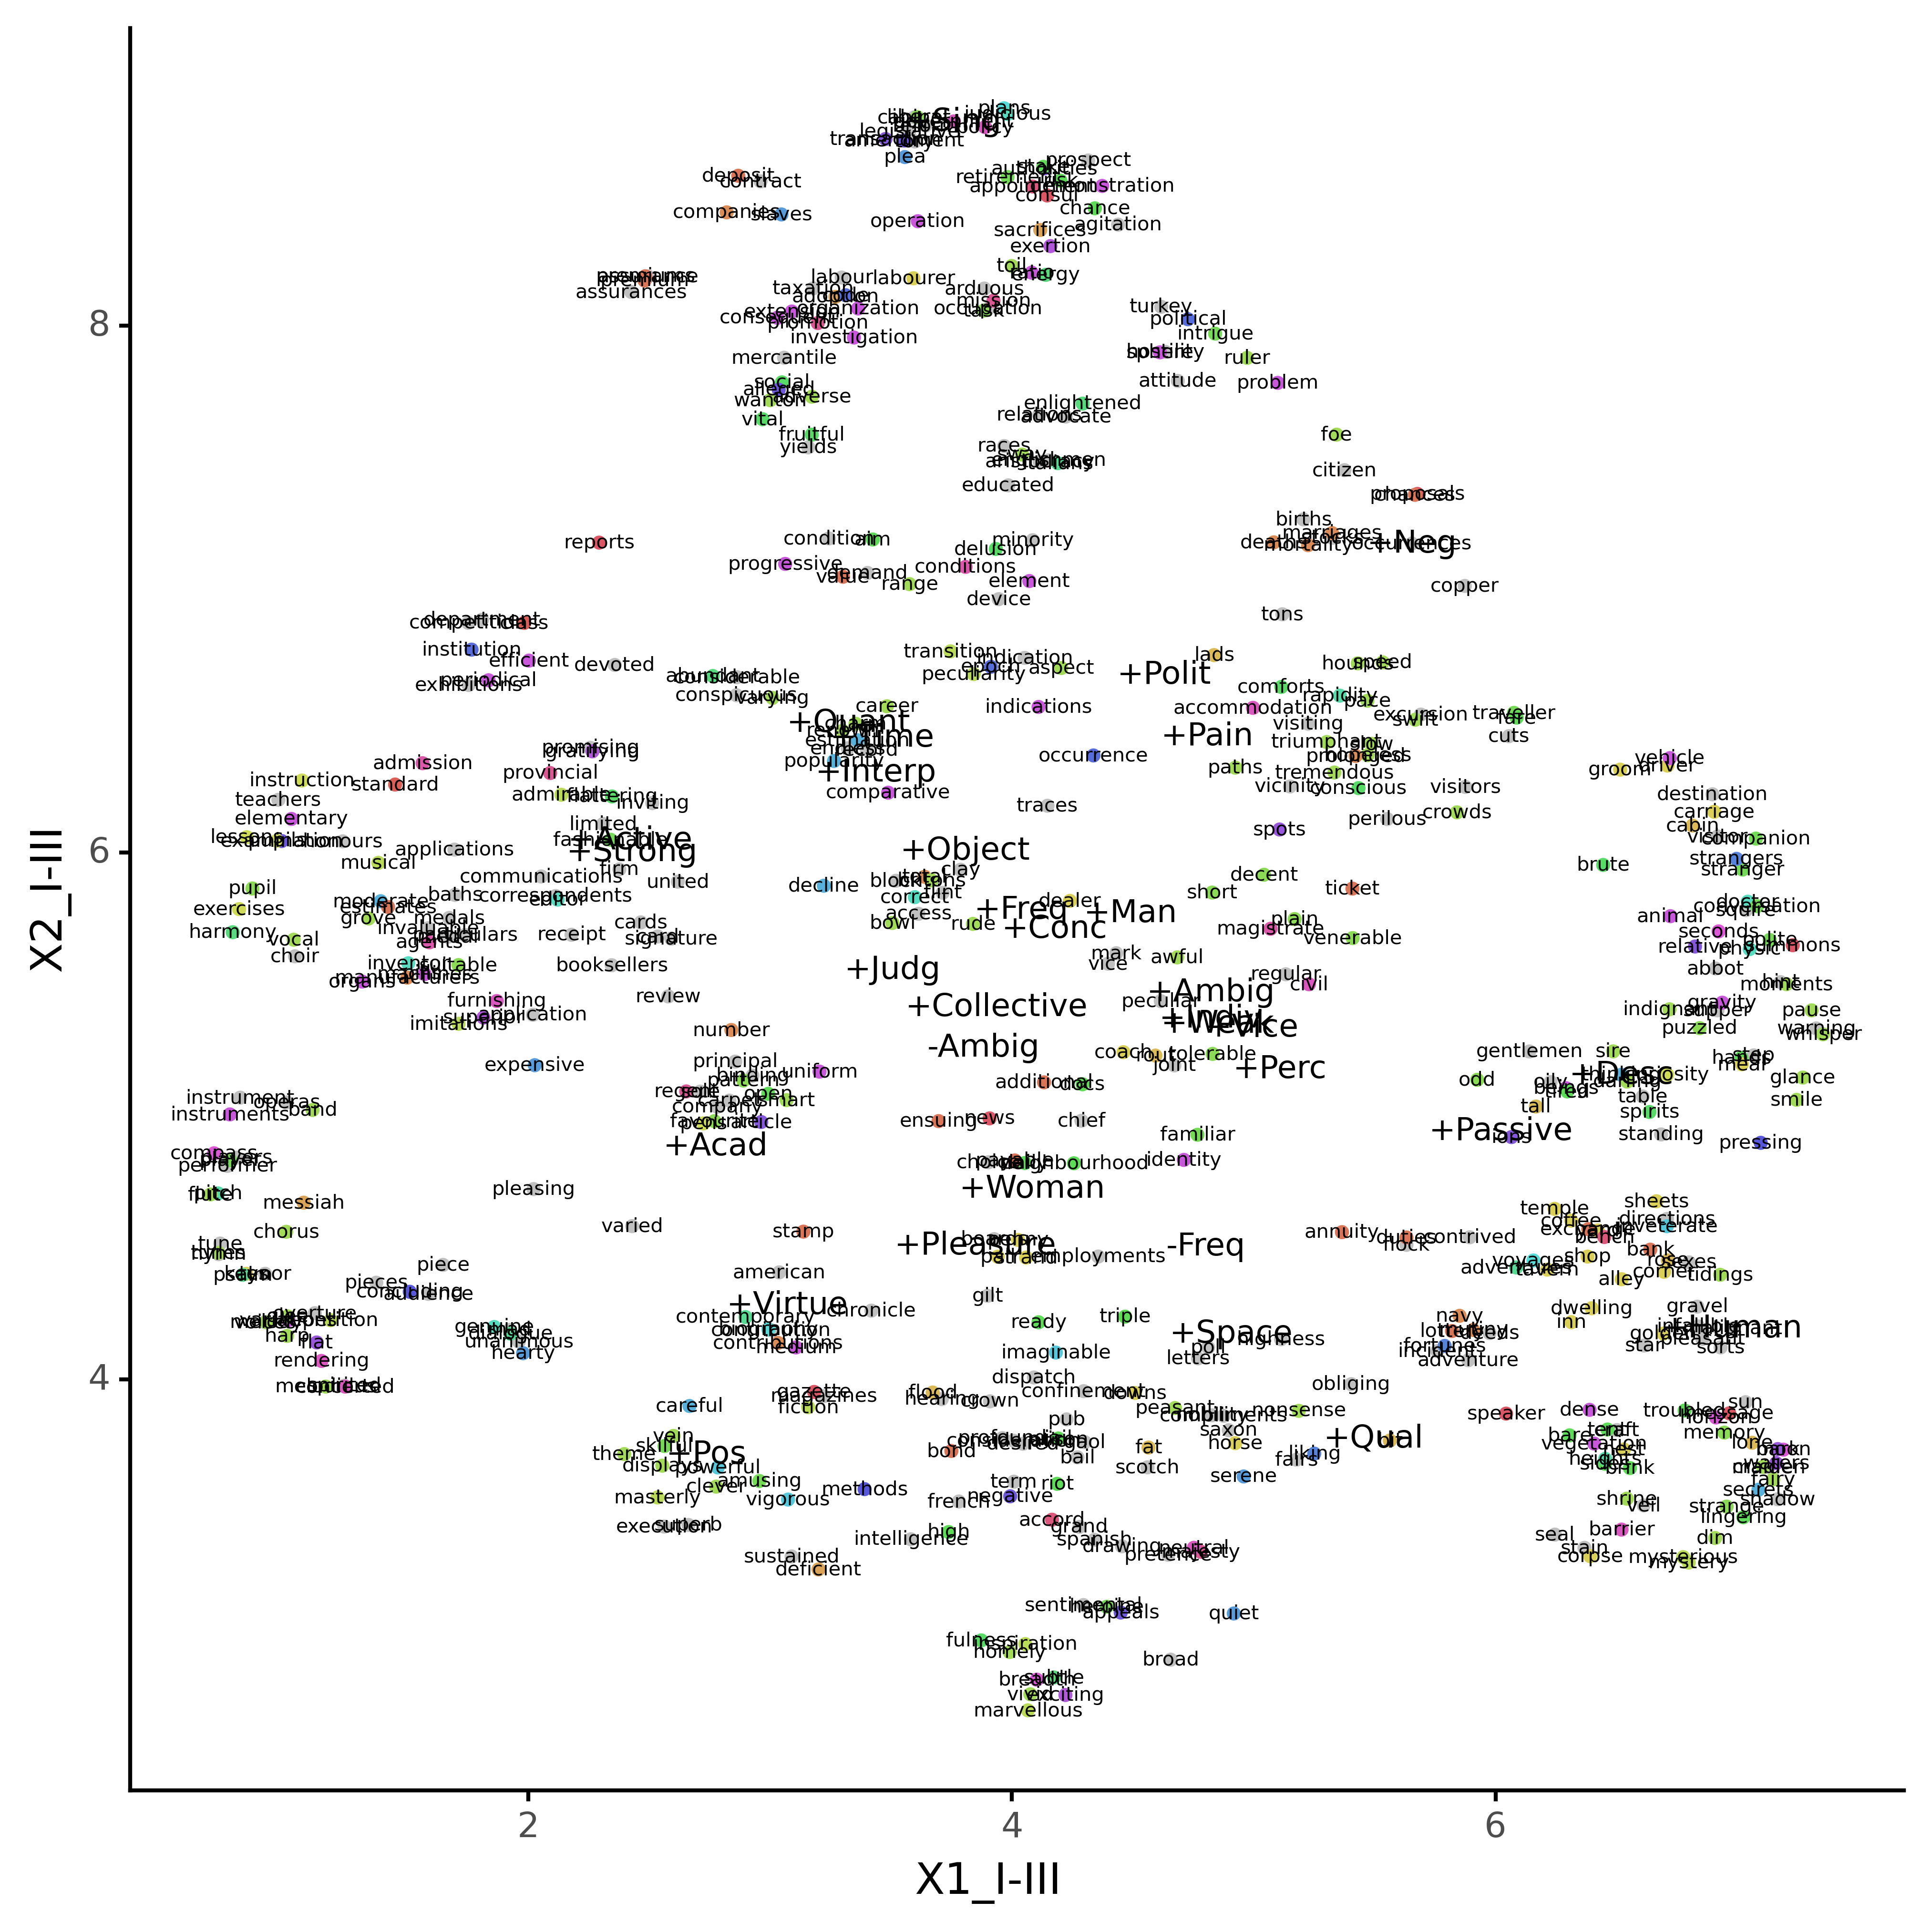

<ggplot: (8761713396013)>

In [153]:
plot_change_vecs(udf=udf2,remove_unclustered='cluster_I-III',color='cluster_I')

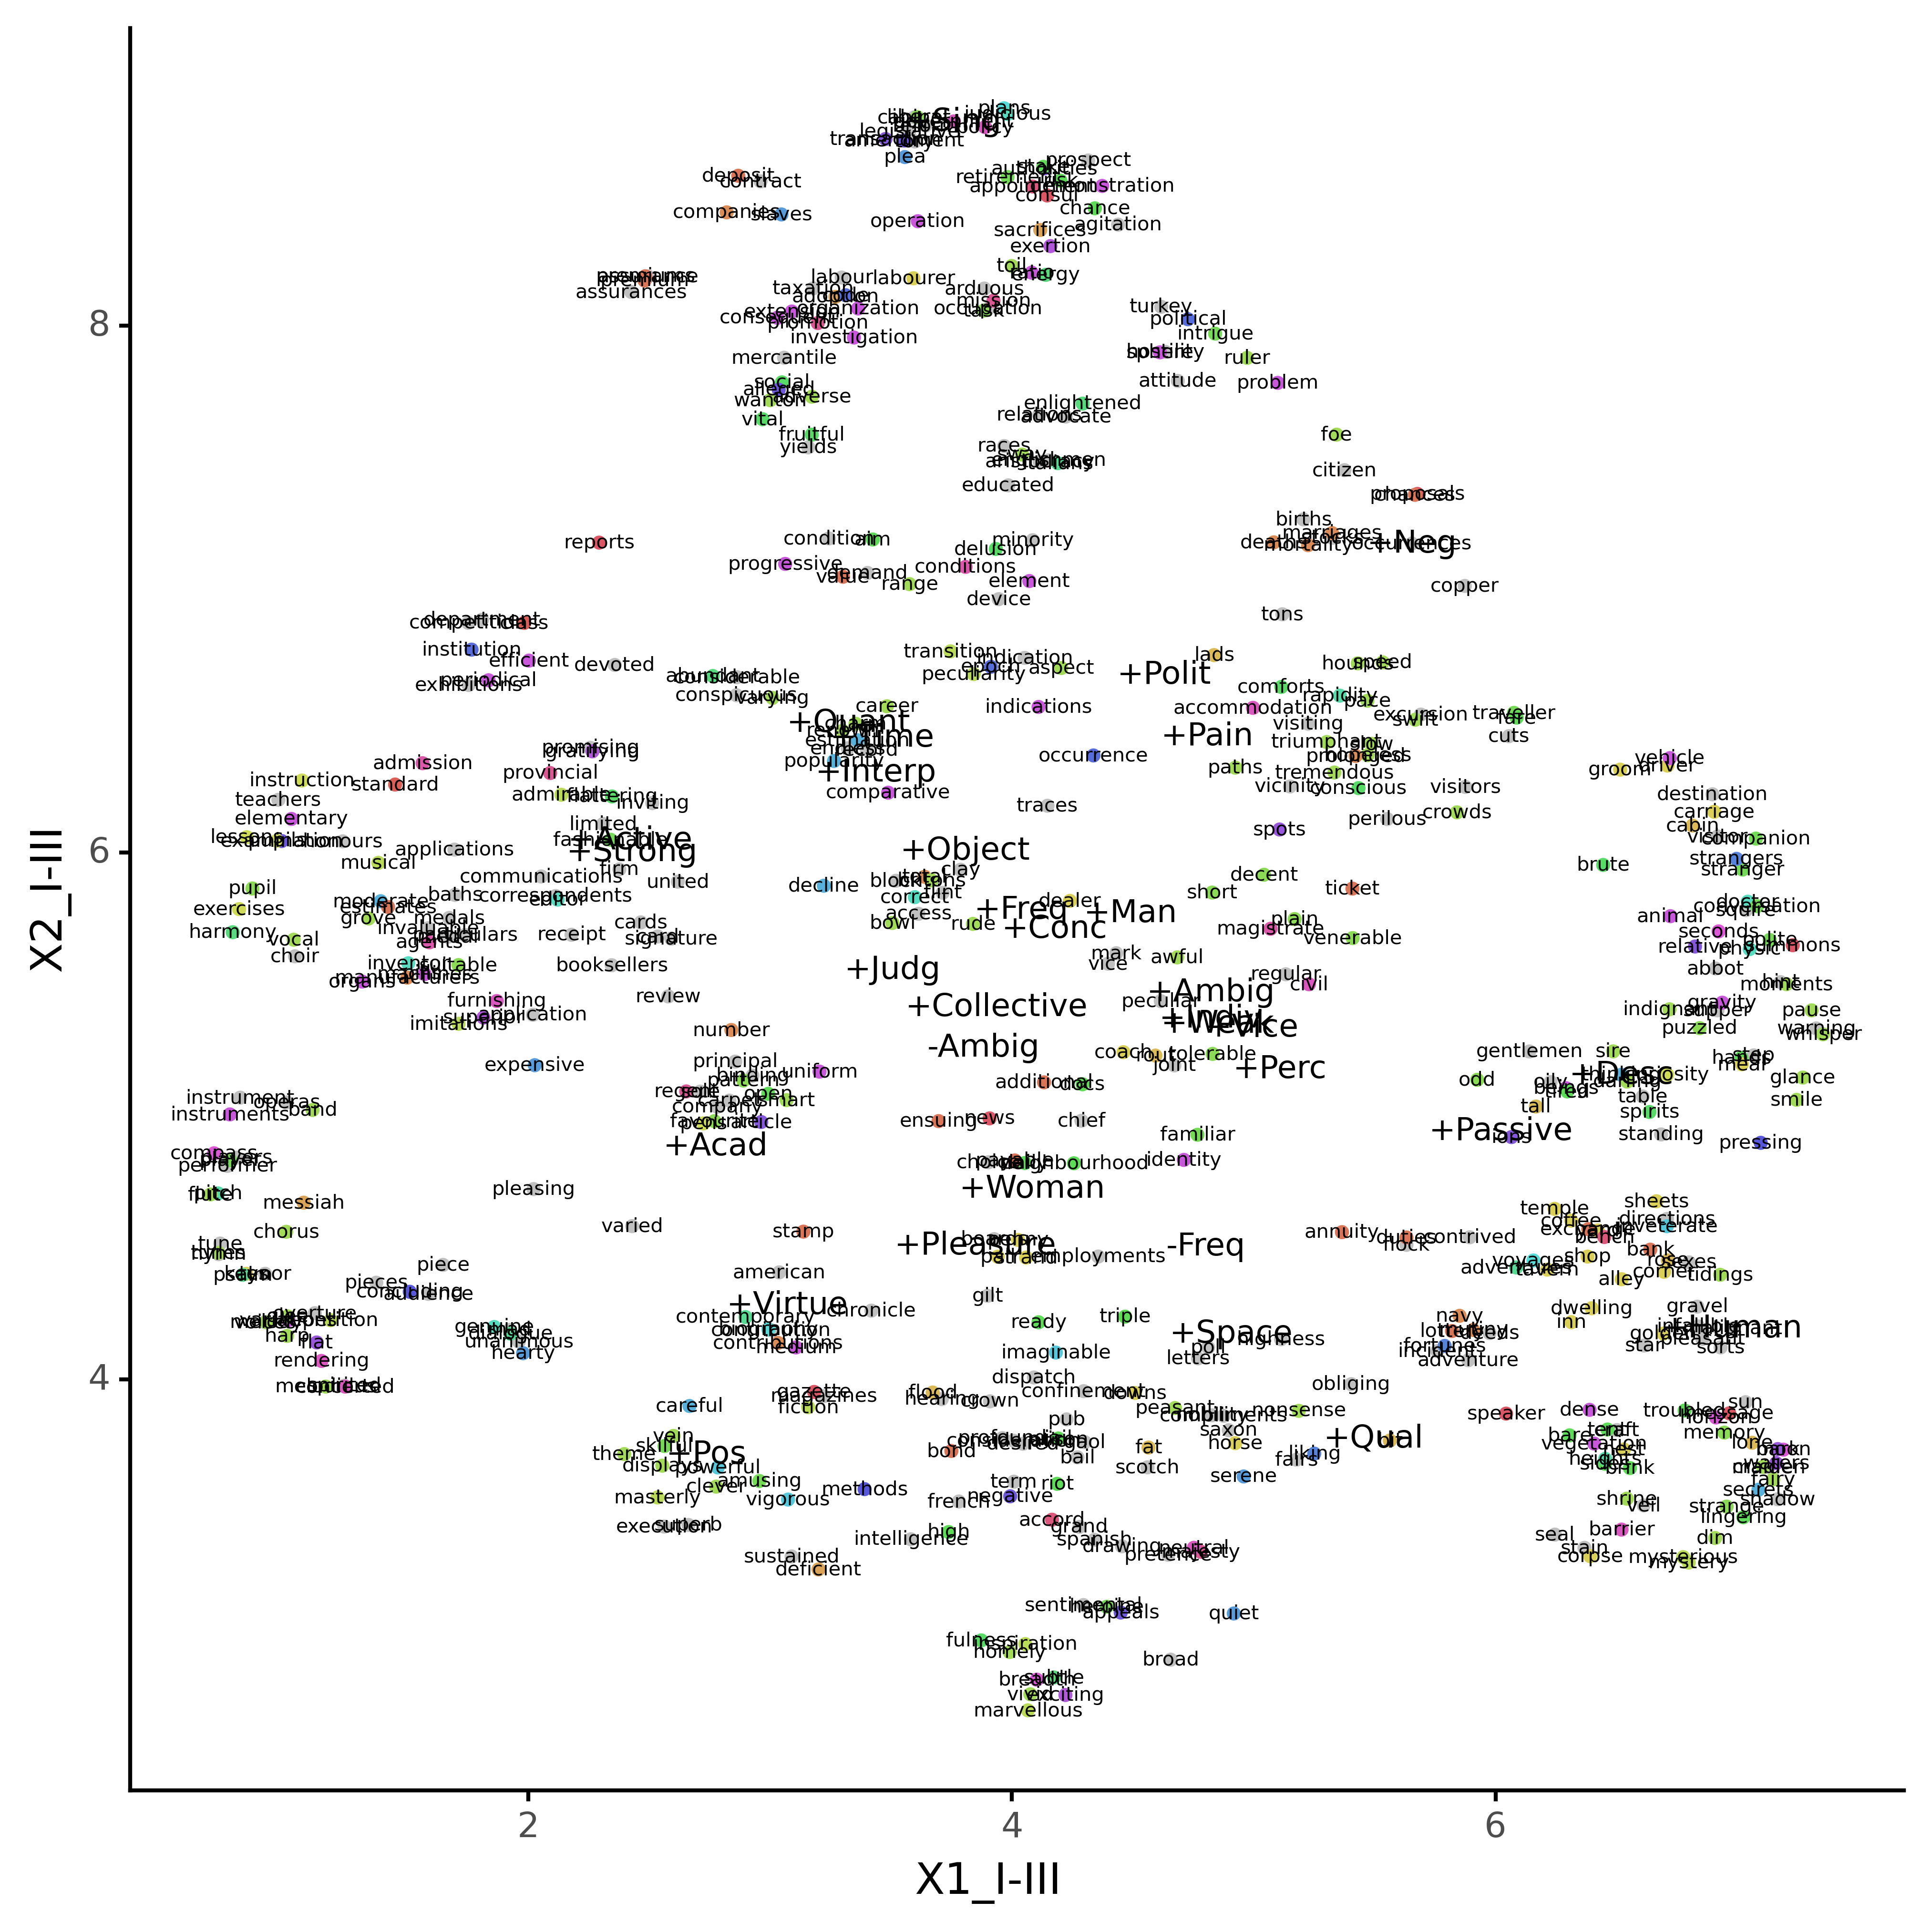

<ggplot: (8761655860865)>

In [154]:
plot_change_vecs(udf=udf2,remove_unclustered='cluster_I-III',color='cluster_I')

In [155]:
# p9.scale_fill_distiller??

In [156]:
# p9.geom_label??

In [157]:
p9.scale_fill

AttributeError: module 'plotnine' has no attribute 'scale_fill'